In [5]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [15]:
data = tfds.load('horses_or_humans', as_supervised=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')
(train_data , val_data , test_data) = data

In [76]:
len(test_data)

256

In [16]:
batch_size = 32
image_size = 224

In [19]:
def map_fn(img , label ) :
  image_height = 224
  image_width = 224
  img = tf.image.resize(img , [image_height , image_width])
  img = img/255.
  return img , label

In [20]:
#TEST CODE:
img , label = list(train_data)[0]
test_result = map_fn(img , label)
print(test_result[0].shape)
print(test_result[1].shape)

(224, 224, 3)
()


In [24]:
def prepare_data(train_data , val_data , test_data, num_exemples , map_fn , batch_size):
  train_ds = train_data.map(map_fn).shuffle(buffer_size=num_exemples).batch(batch_size)
  val_ds = val_data.map(map_fn).batch(batch_size)
  test_ds = test_data.map(map_fn).batch(batch_size)
  return train_ds , val_ds , test_ds

In [26]:
print(len(list(train_data))+ len(list(val_data)))

1027


In [27]:
train_ds , val_ds , test_ds = prepare_data(train_data , val_data , test_data , 1027 , map_fn , batch_size)

In [28]:
for img , label in train_ds :
  print(f'img shape {img.shape} label shape {label.shape}')
  break

img shape (32, 224, 224, 3) label shape (32,)


Define the model

In [37]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(weights='imagenet',include_top=False, input_shape = (224,224,3) )

In [38]:
for layer in resnet.layers:
    layer.trainable = False

In [39]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [93]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet(inputs)  # Assuming `resnet` is your pre-trained ResNet model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512 , activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [94]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               1049088   
                                                                 
 dense_18 (Dense)            (None, 2)                 1026      
                                                          

In [96]:
def set_adam_optimizer() :
  optimizer = tf.keras.optimizers.Adam()
  return optimizer
def set_sparse_cat_crossentropy_loss() :
  train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  return train_loss , val_loss
def set_accuracy_metrice() :
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  return train_accuracy , val_accuracy

In [97]:
optimizer = set_adam_optimizer()
train_loss , val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy , val_accuracy = set_accuracy_metrice()

In [98]:
device = '/gpu:0' if tf.test.is_gpu_available() else '/cpu:0'
EPOCHS = 2
def train_one_step(model , x , y ,optimizer , train_loss , train_accuracy ):
  with tf.GradientTape() as tape :
    y_pred = model(x)
    loss = train_loss(y , y_pred)
  grads = tape.gradient(loss , model.trainable_weights)
  optimizer.apply_gradients(zip(grads , model.trainable_weights))
  train_accuracy.update_state(y, y_pred)
  return loss

In [99]:
## TEST CODE:

def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()
test_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 64)                192       
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
## TEST CODE:

def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.ones((2,2))
test_label = tf.ones((1,))
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_accuracy_metrice()

test_result = train_one_step(test_model, test_image, test_label,test_optimizer, test_train_loss, test_train_accuracy)
print(test_result)


tf.Tensor(0.6931472, shape=(), dtype=float32)


In [101]:
def train(model , optimizer , epochs , device  , train_ds , train_loss ,train_accuracy, valid_ds, val_loss, val_accuracy):
  step = 0
  loss = 0.0
  for epoch in range(epochs) :
    for x , y in train_ds :
      step +=1
      with tf.device(device_name=device) :
        loss = train_one_step(model , x, y ,optimizer ,  train_loss, train_accuracy)
      print('step', step , ':train loss' , loss , ':train accuracy', train_accuracy.result())
    with tf.device(device_name=device):
        for x, y in valid_ds:
          y_pred = model(x)
          loss = val_loss(y, y_pred)
          val_accuracy(y, y_pred)
    print('val loss' , loss , ';val accuracy ' , val_accuracy.result())

In [102]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, val_ds, val_loss, val_accuracy)

step 1 :train loss tf.Tensor(0.6296549, shape=(), dtype=float32) :train accuracy tf.Tensor(0.6875, shape=(), dtype=float32)
step 2 :train loss tf.Tensor(2.1230836, shape=(), dtype=float32) :train accuracy tf.Tensor(0.53125, shape=(), dtype=float32)
step 3 :train loss tf.Tensor(0.689003, shape=(), dtype=float32) :train accuracy tf.Tensor(0.53125, shape=(), dtype=float32)
step 4 :train loss tf.Tensor(1.2269233, shape=(), dtype=float32) :train accuracy tf.Tensor(0.53125, shape=(), dtype=float32)
step 5 :train loss tf.Tensor(1.439867, shape=(), dtype=float32) :train accuracy tf.Tensor(0.525, shape=(), dtype=float32)
step 6 :train loss tf.Tensor(0.84536237, shape=(), dtype=float32) :train accuracy tf.Tensor(0.53125, shape=(), dtype=float32)
step 7 :train loss tf.Tensor(0.7013869, shape=(), dtype=float32) :train accuracy tf.Tensor(0.5089286, shape=(), dtype=float32)
step 8 :train loss tf.Tensor(0.7701868, shape=(), dtype=float32) :train accuracy tf.Tensor(0.51171875, shape=(), dtype=float32)

In [103]:
test_label = []
test_img = []
predection = []
with tf.device(device_name = device) :
  for x , y in train_ds :
    pred = model(x)
    test_label.append(y.numpy())
    predection.append(pred.numpy())
    test_img.append(x.numpy())

In [104]:
test_label[0]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0])

In [105]:
import matplotlib.pyplot as plt
import numpy as np
def show_img(images, true_labels, predicted_labels):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    classes = ['Horse' , 'Human']

    for i in range(10):
        row = i // 5
        col = i % 5
        ax = axes[row, col]

        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'True: {classes[true_labels[i]]}, Predicted: {classes[np.argmax(predicted_labels[i])]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

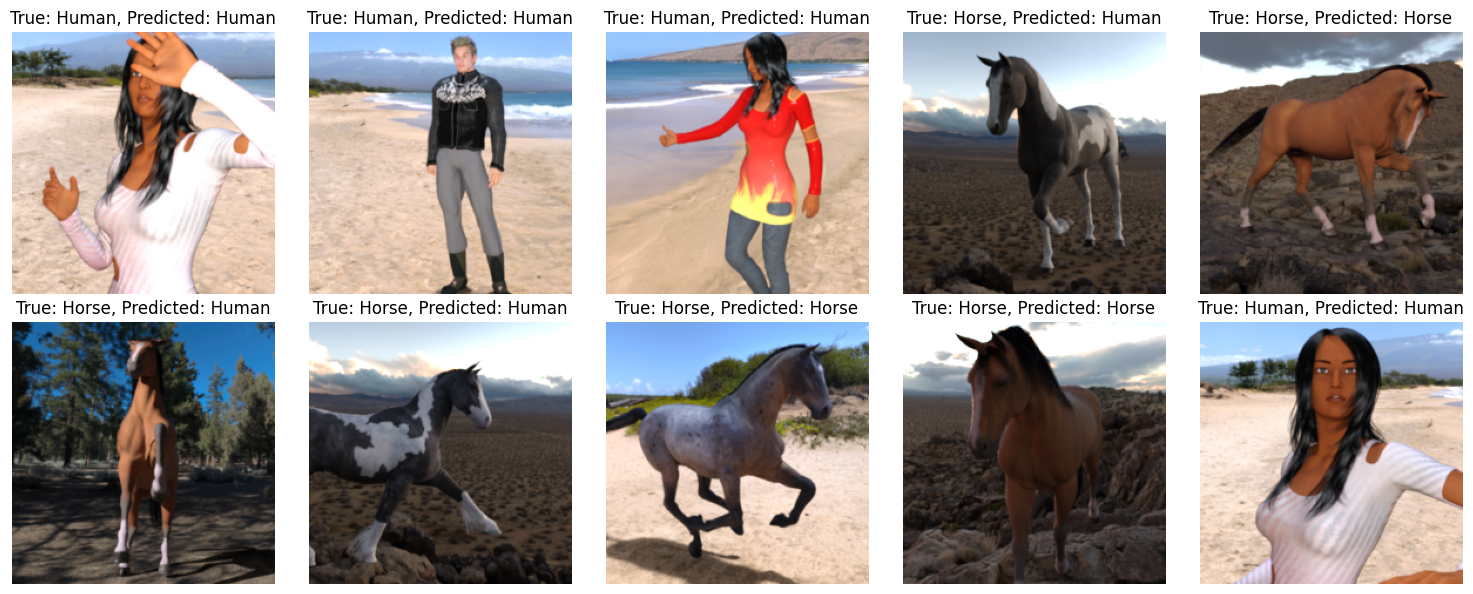

In [106]:
show_img(test_img[0][:11] , test_label[0][:11] , predection[0][:11])

In [107]:
def evaluate(y_pred , y_true) :
  i  =0
  j =0
  for j in range(len(y_true)) :
    k =0
    for k in range(len(y_true[j])):
      if np.argmax(y_pred[j][k]) == y_true[j][k] :
        i +=1
  return i*100/(len(y_true[0])*len(y_true))

In [109]:
evaluate(predection, test_label)

71.03365384615384